# Baroclinic instability in the 2-layer QG model (Phillips problem)

In this notebook we illustrate some elementary aspects of the baroclinic instability in the simplest possible context, that of a two-layer quasi-geostrophic model (the so-called Phillips problem).

The notebook assumes a basic familiarity with the quasi-geostrophic equations and the linear stability problem.

# Code

In this section we define the functions which will allow us to run the simulations and to make plots.

We will use the `dedalus` package, which is a general pseudo-spectral solver for partial differential equations.
Because the goal of the notebook is to explore the physics of the 2-layer model and in particular the baroclinic instability in a short amount of time, we essentially use dedalus as a black box, and do not pay much attentions to the numerical methods used to solve the equations.

First we import the modules we will need.

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NUMEXPR_MAX_THREADS'] = '1'

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import h5py

Now we define the domain and numerical resolution that we will use here: a doubly periodic square domain with 64 grid points in each direction.

In [6]:
# Resolution
N = 64

# Domain
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=N, bounds=(-np.pi, np.pi), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=N, bounds=(-np.pi, np.pi), dealias=3/2)
bases = (xbasis, ybasis)

x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist)

To make it easier to run multiple simulations without having to copy-past the code each time, we define two functions: `build_problem` to build the numerical problem with the desired parameters, and `run_simulation` to run it with chosen numerical parameters (duration of the simulation, name of the output directory, output frequency). To run a simulation, you need to:
- call `build_problem` with the chosen physical parameters
- define the initial condition
- call `run_simulation`

When the simulation is finished, you can read the output file and make all the plots you want to analyse it.

In [54]:
def build_problem(beta=1, U=3, kd2=9, nu=1e-1, alpha=0):
    """
    Create a d3.core.problems.InitialValueProblem object for the two-layer QG model with background shear and return it.

    Keyword Arguments
    -----------------
    beta: float, the gradient of planetary vorticity, beta=2*Omega*cos(phi)/a.
    U: float, the background zonal wind
    kd2: int, the (square of) the deformation wave number
    nu: float, the hyperviscosity coefficient (we use third-order hyperviscosity)
    alpha: float, the bottom friction
    """
    # Define the derivative operators
    dx = lambda A:(d3.Differentiate(A, coords['x']))
    dy = lambda A:(d3.Differentiate(A, coords['y']))

    # Define the fields
    # For the upper-layer
    psi1 = dist.Field(name='psi1', bases=bases) #stream function
    q1 = dist.Field(name='q1', bases=bases) # potential vorticity
    tau_psi1 = dist.Field(name='tau_psi1') # constraint for gauge condition

    # For the lower-layer
    psi2 = dist.Field(name='psi2', bases=bases) # stream function
    q2 = dist.Field(name='q2', bases=bases) # potential vorticity
    tau_psi2 = dist.Field(name='tau_psi2') # constraint for gauge condition

    # Define the problem (equations)
    problem = d3.IVP([psi1, psi2, q1, q2, tau_psi1, tau_psi2], namespace=locals())
    problem.add_equation("dt(q1) + U*dx(q1) + (beta + kd2*U)*dx(psi1) - nu*lap(lap(lap(q1))) = -dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
    problem.add_equation("dt(q2) - U*dx(q2) + (beta - kd2*U)*dx(psi2) - nu*lap(lap(lap(q2))) + alpha*lap(psi2) = -dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
    problem.add_equation("integ(psi1) = 0") # gauge condition, otherwise the problem is ill-defined
    problem.add_equation("integ(psi2) = 0") # gauge condition, otherwise the problem is ill-defined
    problem.add_equation("q1 - lap(psi1) - (kd2/2)*(psi2-psi1) + tau_psi1 = 0")
    problem.add_equation("q2 - lap(psi2) - (kd2/2)*(psi1-psi2) + tau_psi2 = 0")

    return problem, psi1, psi2, q1, q2

def run_simulation(name, problem, psi1, psi2, q1, q2, stop_sim_time = 5, initial_timestep = 1e-3, snap_dt=1e-1):
    """
    Run a simulation with dedalus and create output files.

    Parameters
    ----------
    name: str, the name of the simulation, used for the directory containing output files
    problem: d3.core.problems.InitialValueProblem object, the problem to solve

    Keyword Arguments
    -----------------
    stop_sim_time: float, the total duration of the simulation (default 5.0)
    initial_timestep: float, an initial value for the timestep, overridden by the adapative time step in subsequent steps (default 1e-3)
    snap_dt: float, the output frequency (default 0.1). Decrease it if necessary to keep output files of reasonable size.
    """
    # Define the time-stepping method
    timestepper = d3.RK443
    # Build the solver
    solver = problem.build_solver(timestepper)
    solver.stop_sim_time = stop_sim_time
    # Configure adaptive time-stepping
    CFL = d3.CFL(solver, initial_dt=initial_timestep, max_dt=1e-1)
    dx = lambda A:(d3.Differentiate(A, coords['x']))
    dy = lambda A:(d3.Differentiate(A, coords['y']))
    CFL.add_velocity(-dy(psi1)*ex + dx(psi1)*ey)

    # Configure the data to store in output files
    snapshots = solver.evaluator.add_file_handler(name, sim_dt=snap_dt)
    snapshots.add_task(psi1, name='psi1')
    snapshots.add_task(q1, name='vorticity1')
    snapshots.add_task(psi2, name='psi2')
    snapshots.add_task(q2, name='vorticity2')
    snapshots.add_task(d3.Integrate((dx(psi1))**2 + (dy(psi1))**2, ('x', 'y')), name='KE1')
    snapshots.add_task(d3.Integrate((dx(psi2))**2 + (dy(psi2))**2, ('x', 'y')), name='KE2')

    # Actually run the simulation
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if solver.iteration % 100 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))

    # Post-processing: add parameter values to output files
    with h5py.File(f"{name}/{name}_s1.h5", 'r+') as datafile:
        datafile.attrs['mean_flow'] = problem.namespace['U']
        datafile.attrs['beta'] = problem.namespace['beta']
        datafile.attrs['kd'] = np.sqrt(problem.namespace['kd2'])
        datafile.attrs['nu'] = problem.namespace['nu']
        datafile.attrs['alpha'] = problem.namespace['alpha']

Next we define functions to create plots from Dedalus output:

In [39]:
def plot_energy(dir_path):
    """
    Plot energy as a function of time.

    Parameters
    ----------
    dir_path: str, the path to the directory containing the HDF5 output generated by Dedalus.
    """
    ax = plt.axes(xlabel=r'$t$', ylabel='Energy', yscale='log')
    ax.grid(color='grey', ls='dotted')
    with h5py.File(f"{dir_path}/{dir_path}_s1.h5") as file:
        time = file['scales']['sim_time'][:]
        for label in ('KE1', 'KE2'):
            ax.plot(time, file['tasks'][label][:, 0, 0], label=label)
    ax.legend()  

In [3]:
def animation_streamfunction(file_path, plot_full=False):
    """
    Plot an animation with four panels showing the streamfunction and potential vorticity in each layer.

    Parameters
    ----------
    file_path: str, the path to the HDF5 output generated by Dedalus.

    Keyword Arguments
    -----------------
    plot_full: bool, whether to show only the perturbation (default) or the full fields.
    """
    # Create figure with four panels
    fig, axes = plt.subplots(2, 2, figsize=(12.8, 9.6))

    # Read data from Dedalus output file
    with h5py.File(file_path) as file:
        psi1 = file['tasks']['psi1'][:]
        psi2 = file['tasks']['psi2'][:]
        q1 = file['tasks']['vorticity1'][:]
        q2 = file['tasks']['vorticity2'][:]
        time = file['scales']['sim_time'][:]
        params = dict(file.attrs)

    # Add background fields to perturbations if showing the full fields
    plot_type = "Perturbation"
    if plot_full:
        _, Nx, Ny = psi1.shape
        x = np.linspace(-np.pi, np.pi, Nx)
        y = np.linspace(-np.pi, np.pi, Ny)
        _, _, Y = np.meshgrid(x, time, y)
        psi1 = psi1 - params['mean_flow']*Y
        psi2 = psi2 + params['mean_flow']*Y
        q1 = q1 + (params['beta']+params['kd']**2*params['mean_flow'])*Y
        q2 = q2 + (params['beta']-params['kd']**2*params['mean_flow'])*Y
        plot_type = "Full field"
    fig.suptitle(f"{plot_type}, t=0")

    # Define auxiliary function to plot a field in a given panel
    def create_plot(ax, field, label):
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        im = ax.imshow(field[0].T, extent=[-np.pi, np.pi, -np.pi, np.pi], cmap='RdBu_r', origin='lower')
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(label)
        return im, cbar

    # Plot the four initial snapshots
    im_list, cbar_list = [], []
    for index, field, label in zip(range(4), (psi1, psi2, q1, q2), ('Streamfunction Top Layer', 'Streamfunction Bottom Layer', 'PV Top Layer', 'PV Bottom Layer')):
        ax = axes[int(index/2)][index%2]
        im, cbar = create_plot(ax, field, label)
        im_list.append(im)
        cbar_list.append(cbar)
    plt.tight_layout()

    # Define auxiliary function to update the four panels
    def animate(i):
        fig.suptitle(f"{plot_type}, t={time[i]:.2f}")
        for im, cbar, field in zip(im_list, cbar_list, (psi1, psi2, q1, q2)):
            im.set_data(field[i].T)
            im.set_clim(np.min(field[i]), np.max(field[i]))  # Update colorbar limits dynamically
            cbar.update_normal(im)  # Update the colorbar to reflect the new image data
        return [im]

    # Create the animation using the above function
    ani = animation.FuncAnimation(fig, animate, frames=len(psi1), interval=50, blit=False)

    return ani

<div class="alert alert-warning">

In some cases, `matplotlib` might complain that the animation exceeds the allowed size. In that case you can run the following command to increase the allowed size:
```
plt.rc('animation', embed_limit=50)
```
to extend it to 50MB. The default value should be 20MB. You can check it with:
```
import matplotlib as mpl
mpl.rcParams['animation.embed_limit']
```

Alternatively, you can decrease the output frequency by adjusting the `snap_dt` parameter when running the simulation (remember that any machine has finite resources...).

</div>

In [42]:
plt.rc('animation', embed_limit=50)

# Rossby waves in the 2-layer model

We start by simulating the free modes of the 2-layer model in the absence of background flow ($U=0$), but with a gradient of planetary vorticity ($\beta \neq 0$).

Simulate the evolution of a small amplitude monochromatic perturbation $\psi_1'=\psi_0 e^{i(kx+\ell y)}$ in the upper layer, with two vertical structures: $\psi_2'=\psi_1'$ or $\psi_2'=-\psi_1'$.
In each case:
- plot an animation to check visually that the perturbation indeed propagates zonnally while preserving its space-time coherence.
- make a Hovmoller diagram to check that the phase speed agrees with theory.

For these simulations you do not need to add viscosity, you can set $\nu=0$.

Does the amplitude of the perturbation evolve in time in the absence of dissipation?
What is the sign of the background potential vorticity gradient in each layer?
How are these two things related?

<div class="alert alert-info">

*Note on parameter values*
    
Typical parameter values for the mid-latitude atmosphere or ocean would be $\beta\approx 1.5e^{-11}$ m^{-1}.s^{-1}.
    
Now, the equations above are written in dimensional form, but we choose a domain of size 2\pi, which amounts at non-dimensionalizing the $x$ and $y$ coordinates by a scale $L$ (for a circle at latitude 45, for instance, the unit lenght $L$ is on the order of 4500km). Hence all the parameters should be written with the corresponding unit length. In addition, it is natural here to choose $(\beta{}L)^{-1}$ as the unit time. With this choice, the only remaining parameter is the deformation radius, which is on order 10 or so in this unit system. Hence in this section we should run simulations using the code above with $\beta=1$ and $k_d=10$.

</div>


In [21]:
kd2 = 100
problem, psi1, psi2, q1, q2 = build_problem(beta=1, U=0, kd2=100, nu=0, alpha=0)

# Initial condition
psi_tilde = 0.01
k, l = 1, 0
x, y = dist.local_grids(xbasis, ybasis)
psi1['g'] = psi_tilde*np.cos(k*x + l*y)
psi2['g'] = psi_tilde*np.cos(k*x + l*y)
K_carre = k**2 + l**2
q1['g'] = -K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi2['g']-psi1['g'])
q2['g'] = -K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi1['g']-psi2['g'])

run_simulation(f"phillips_beta=1_U=0_kd2=100_ic_k1_l0_barotropic", problem, psi1, psi2, q1, q2, stop_sim_time=10, initial_timestep=1e-2)

2025-11-15 18:03:44,754 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+01/s
2025-11-15 18:03:44,789 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+01/s
2025-11-15 18:03:44,824 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 9.8e+01/s
2025-11-15 18:03:44,859 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2025-11-15 18:03:44,893 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2025-11-15 18:03:44,927 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2025-11-15 18:03:44,960 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2025-11-15 18:03:44,994 subsystems 0/1 INFO :: Building subproblem matric

In [ ]:
HTML(animation_streamfunction("phillips_beta=1_U=0_kd2=100_ic_k1_l0_barotropic/phillips_beta=1_U=0_kd2=100_ic_k1_l0_barotropic_s1.h5").to_jshtml())

Text(0.5, 1.0, 'Lower layer')

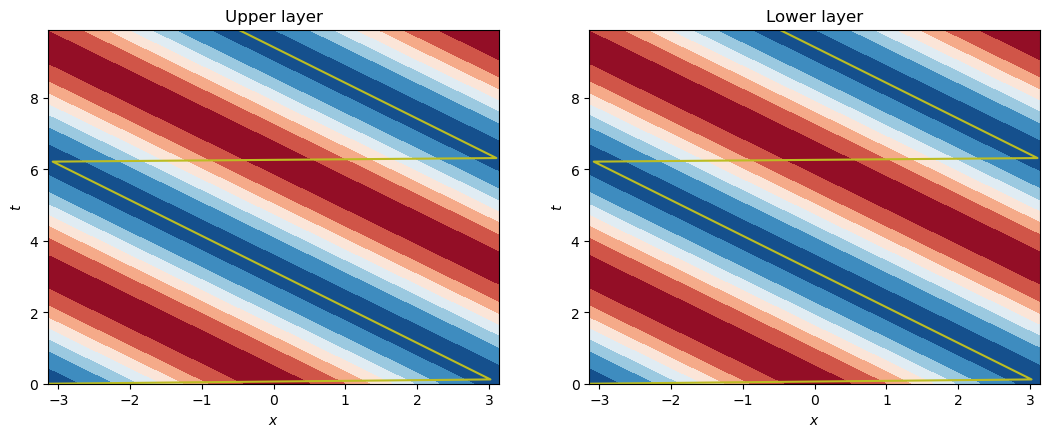

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.6))

with h5py.File("phillips_beta=1_U=0_kd2=100_ic_k1_l0_barotropic/phillips_beta=1_U=0_kd2=100_ic_k1_l0_barotropic_s1.h5") as file:
    psi1 = file['tasks']['psi1'][:]
    psi2 = file['tasks']['psi2'][:]
    q1 = file['tasks']['vorticity1'][:]
    q2 = file['tasks']['vorticity2'][:]
    time = file['scales']['sim_time'][:]
    params = dict(file.attrs)

    _, Nx, _ = psi1.shape
    x = np.linspace(-np.pi, np.pi, Nx)
    X, T = np.meshgrid(x, time)
    ax1.contourf(X, T, psi1[:, :, 0], cmap='RdBu_r')
    ax2.contourf(X, T, psi2[:, :, 0], cmap='RdBu_r')

for ax in (ax1, ax2):
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    ax.plot(-time%(2*np.pi)-np.pi, time, color='C8')
ax1.set_title("Upper layer")
ax2.set_title("Lower layer")


This Hovmoller diagram shows that the barotropic wave with $k=1$ and $\ell=0$ propagates westward with c=-1 phase speed in our unit system (the dimensional version is $c=-\beta/(k^2+\ell^2)$).

Now we move to the baroclinic wave. Because it is much slower we need to run the simulation much longer.

In [12]:
kd2 = 100
problem, psi1, psi2, q1, q2 = build_problem(beta=1, U=0, kd2=100, nu=0, alpha=0)

# Initial condition
psi_tilde = 0.01
k = 1
l = 0
x, y = dist.local_grids(xbasis, ybasis)
psi1['g'] = psi_tilde*np.cos(k*x + l*y)
psi2['g'] = -psi_tilde*np.cos(k*x + l*y)
K_carre = k**2 + l**2
q1['g'] = -K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi2['g']-psi1['g'])
q2['g'] = K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi1['g']-psi2['g'])

run_simulation(f"phillips_beta=1_U=0_kd2=100_ic_k1_l0_baroclinic", problem, psi1, psi2, q1, q2, stop_sim_time=100, initial_timestep=1e-2, snap_dt=1)

2025-11-12 21:45:19,729 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+01/s
2025-11-12 21:45:19,760 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 9.1e+01/s
2025-11-12 21:45:19,795 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2025-11-12 21:45:19,830 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2025-11-12 21:45:19,865 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2025-11-12 21:45:19,898 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2025-11-12 21:45:19,933 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2025-11-12 21:45:19,969 subsystems 0/1 INFO :: Building subproblem matric

In [ ]:
HTML(animation_streamfunction("phillips_beta=1_U=0_kd2=100_ic_k1_l0_baroclinic/phillips_beta=1_U=0_kd2=100_ic_k1_l0_baroclinic_s1.h5").to_jshtml())

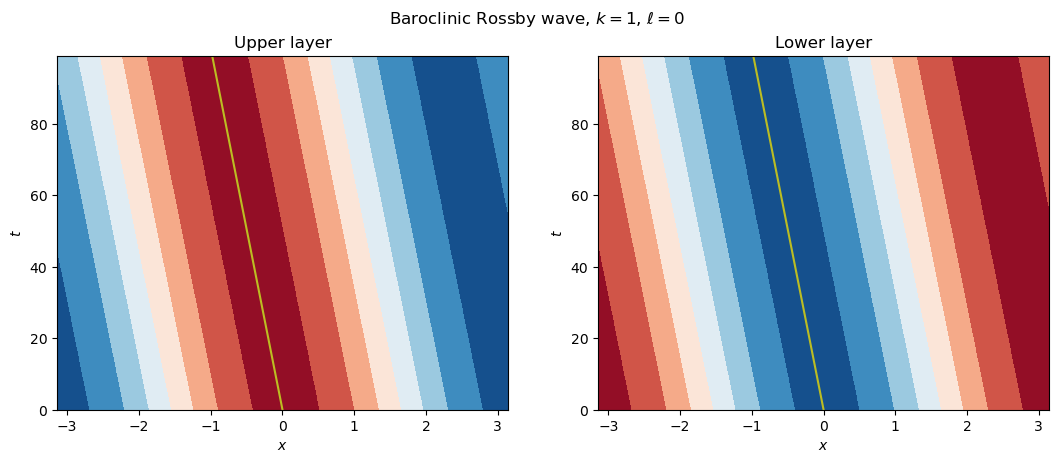

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.6))
fig.suptitle(r'Baroclinic Rossby wave, $k=1$, $\ell=0$')

with h5py.File("phillips_beta=1_U=0_kd2=100_ic_k1_l0_baroclinic/phillips_beta=1_U=0_kd2=100_ic_k1_l0_baroclinic_s1.h5") as file:
    psi1 = file['tasks']['psi1'][:]
    psi2 = file['tasks']['psi2'][:]
    q1 = file['tasks']['vorticity1'][:]
    q2 = file['tasks']['vorticity2'][:]
    time = file['scales']['sim_time'][:]
    params = dict(file.attrs)

    _, Nx, _ = psi1.shape
    x = np.linspace(-np.pi, np.pi, Nx)
    X, T = np.meshgrid(x, time)
    ax1.contourf(X, T, psi1[:, :, 0], cmap='RdBu_r')
    ax2.contourf(X, T, psi2[:, :, 0], cmap='RdBu_r')

for ax in (ax1, ax2):
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    ax.plot(-time/101, time, color='C8')
ax1.set_title("Upper layer")
ax2.set_title("Lower layer");

The baroclinic wave too propagates westward with the expected phase speed, which in our unit system is $c=-1/101$ for $k=1$, $\ell=0$. The dimensional expression is $c=-\beta/(k^2+\ell^2+k_d^2)$.

# Baroclinic instability on the f-plane ($\beta=0$)

In the above section, we have seen that with beta effect but in the absence of vertical shear, the 2-layer QG model is stable and supports two westward propagating modes. Now we will study the opposite situation, with vertical shear ($U>0$) but no beta effect. This is the simplest setup for baroclinic instability.

Again rather than using dimensional values for $U$, we shall use $T=L/U$ as the time unit, which amounts at simply setting $U=1$ in the dimensional equations with $\beta=0$. We keep $k_{d}=10$.

- run a simulation with the following initial condition: $\psi_{1}'=\psi_0e^{i(kx+\ell{}y)}$, $\psi_{1}'=\psi_0e^{i(kx+\ell{}y+\pi/4)}$. Plot an animation of the evolution of the stream function and potential vorticity in the two layers, and the evolution in time of the kinetic energy in each layer. Identify the different stages of the simulation: in particular, do you observe a behavior compatible with the linear stability analysis of the Phillips problem?
  For this simulation you will need to add a small viscosity to avoid the build-up of enstrophy at the end of the exponential growth stage. With the hyperviscosity used in the code, you can choose $\nu=10^{-4}$.
- does the evolution depend on the initial condition?
- what is the meridional and zonal wavenumber of the unstable perturbation? Is this compatible with the linear theory? Why do you always observe this mode regardless of the initial condition?
- compare the stream function in the two layers in the linear instability regime: is there a phase difference? Compared to the background vertical shear, does it go in the same direction or in the opposite direction?

In [73]:
kd2 = 100
problem, psi1, psi2, q1, q2 = build_problem(beta=0, U=1, kd2=100, nu=1e-4, alpha=0)

# Initial condition
psi_tilde = 1e-2
k = 6
l = 2
x, y = dist.local_grids(xbasis, ybasis)
psi1['g'] = 3*psi_tilde*np.cos(k*x + l*y)
psi2['g'] = psi_tilde*np.cos(k*x + l*y+np.pi/4)
K_carre = k**2 + l**2
q1['g'] = -3*K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi2['g']-psi1['g'])
q2['g'] = -K_carre*psi_tilde*np.cos(k*x + l*y+np.pi/4) + (kd2/2)*(psi1['g']-psi2['g'])

run_simulation(f"phillips_beta=0_U=1_kd2=100_ic_k6_l2", problem, psi1, psi2, q1, q2, stop_sim_time=16, initial_timestep=1e-2)

2025-11-13 20:30:00,930 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 5.2e+01/s
2025-11-13 20:30:00,982 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+01/s
2025-11-13 20:30:01,155 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 3.3e+01/s
2025-11-13 20:30:01,222 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s
2025-11-13 20:30:01,287 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2025-11-13 20:30:01,352 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+01/s
2025-11-13 20:30:01,417 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 4.7e+01/s
2025-11-13 20:30:01,480 subsystems 0/1 INFO :: Building subproblem matric

In [ ]:
HTML(animation_streamfunction("phillips_beta=0_U=1_kd2=100_ic_k6_l2/phillips_beta=0_U=1_kd2=100_ic_k6_l2_s1.h5").to_jshtml())

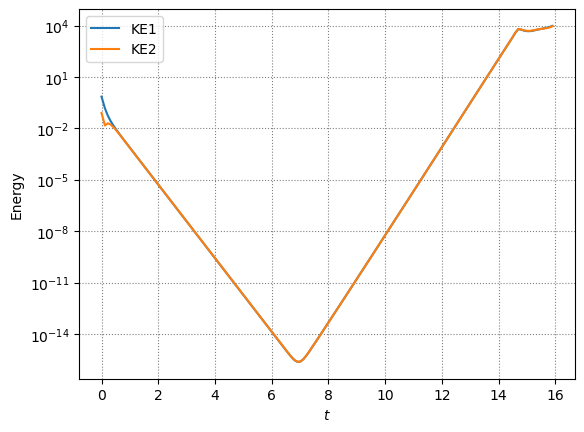

In [38]:
plot_energy("phillips_beta=0_U=1_kd2=100_ic_k6_l2")

In this simulation, the initial condition first undergoes an exponential decay until about t=7. At about this time, it loses its initial plane wave structure, and takes the form of an almost meridionnaly-invariant perturbation with zonal wavenumber 4, corresponding more or less to the most unstable mode of the Phillips problem. This mode grows in place at an exponential rate, until the instability saturates at $t\approx 15$. Then the system starts becoming turbulent and forming eddies.

Note that in the linear instability stage, the vertical tilt of the unstable mode is westward, i.e. into the shear, as expected from theory.

In [58]:
kd2 = 100
problem, psi1, psi2, q1, q2 = build_problem(beta=0, U=1, kd2=100, nu=1e-4, alpha=0)

# Initial condition
psi_tilde = 1e-2
k = 12
l = 2
x, y = dist.local_grids(xbasis, ybasis)
psi1['g'] = 3*psi_tilde*np.cos(k*x + l*y)
psi2['g'] = psi_tilde*np.cos(k*x + l*y+np.pi/4)
K_carre = k**2 + l**2
q1['g'] = -3*K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi2['g']-psi1['g'])
q2['g'] = -K_carre*psi_tilde*np.cos(k*x + l*y+np.pi/4) + (kd2/2)*(psi1['g']-psi2['g'])

run_simulation(f"phillips_beta=0_U=1_kd2=100_ic_k12_l2", problem, psi1, psi2, q1, q2, stop_sim_time=15, initial_timestep=1e-2)

2025-11-12 23:34:02,520 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 4.7e+01/s
2025-11-12 23:34:02,572 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 5.4e+01/s
2025-11-12 23:34:02,640 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+01/s
2025-11-12 23:34:02,706 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s
2025-11-12 23:34:02,770 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+01/s
2025-11-12 23:34:02,833 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+01/s
2025-11-12 23:34:02,895 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s
2025-11-12 23:34:02,955 subsystems 0/1 INFO :: Building subproblem matric

In [ ]:
HTML(animation_streamfunction("phillips_beta=0_U=1_kd2=100_ic_k12_l2/phillips_beta=0_U=1_kd2=100_ic_k12_l2_s1.h5").to_jshtml())

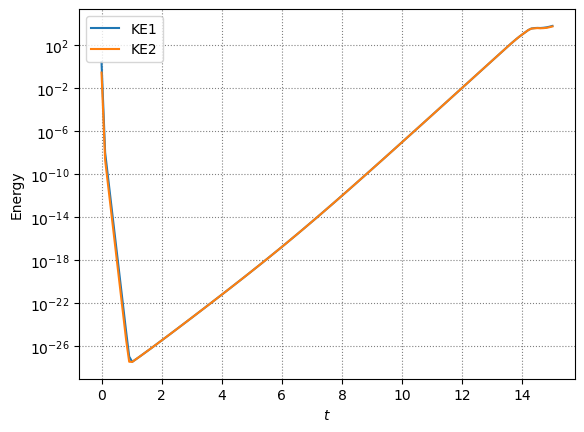

In [45]:
plot_energy("phillips_beta=0_U=1_kd2=100_ic_k12_l2")

# With beta effect

We now look at the effect of differential rotation on the baroclinic instability.

Keeping the same value as above for all the other parameters, progressivelt increase $\beta$ and observe its effect on the dynamics. In particular:
- check that with increasing $\beta$, the wavelength of the most unstable mode and its growth rate both decrease.
- check that for $\beta$ large enough, the instability disappears. Why is that?
- describe the effect of $\beta$ on the shape of the equilibrated flow.

Note: in our unit system, we could estimate that typical values of $\beta$ for the atmosphere should be of order 10 and of order 100 for the ocean.

## Small $\beta$: $\beta=O(1)$

In [40]:
kd2 = 100
problem, psi1, psi2, q1, q2 = build_problem(beta=1, U=1, kd2=100, nu=1e-4, alpha=0)

# Initial condition
psi_tilde = 1e-2
k = 6
l = 2
x, y = dist.local_grids(xbasis, ybasis)
psi1['g'] = 3*psi_tilde*np.cos(k*x + l*y)
psi2['g'] = psi_tilde*np.cos(k*x + l*y+np.pi/4)
K_carre = k**2 + l**2
q1['g'] = -3*K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi2['g']-psi1['g'])
q2['g'] = -K_carre*psi_tilde*np.cos(k*x + l*y+np.pi/4) + (kd2/2)*(psi1['g']-psi2['g'])

run_simulation(f"phillips_beta=1_U=1_kd2=100_ic_k6_l2", problem, psi1, psi2, q1, q2, stop_sim_time=16, initial_timestep=1e-2)

2025-11-14 16:24:29,923 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 3.2e+01/s
2025-11-14 16:24:30,014 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 3.3e+01/s
2025-11-14 16:24:30,145 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 3.2e+01/s
2025-11-14 16:24:30,249 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s
2025-11-14 16:24:30,357 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2025-11-14 16:24:30,472 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.4e+01/s
2025-11-14 16:24:30,569 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.5e+01/s
2025-11-14 16:24:30,667 subsystems 0/1 INFO :: Building subproblem matric

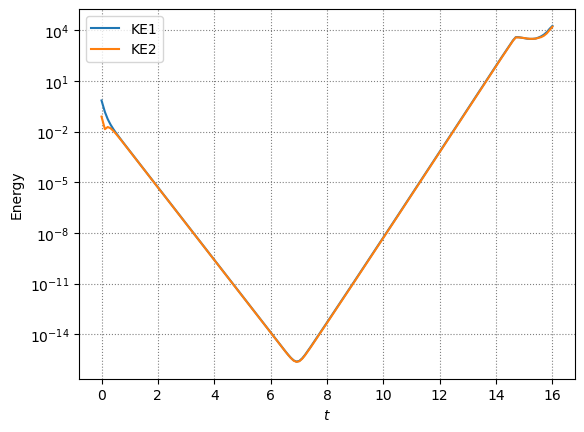

In [46]:
plot_energy("phillips_beta=1_U=1_kd2=100_ic_k6_l2")

In [ ]:
HTML(animation_streamfunction("phillips_beta=1_U=1_kd2=100_ic_k6_l2/phillips_beta=1_U=1_kd2=100_ic_k6_l2_s1.h5").to_jshtml())

For $\beta$ of order one, the solution is very close to the solution on the $f$-plane.

## Medium $\beta$: $\beta$=O(10)

We increase $\beta$ to reach a regime where we should expect it to have an effect: as estimated above beta of order 10 corresponds to typical values for the parameters in the mid-latitude atmosphere. In addition, we can check from linear instability theory that this is the range where the beta effect becomes non-negligible.

We first pick $\beta=10$, and we will increase it even further later.

In [35]:
kd2 = 100
problem, psi1, psi2, q1, q2 = build_problem(beta=10, U=1, kd2=100, nu=1e-4, alpha=0)

# Initial condition
psi_tilde = 1e-2
k = 6
l = 2
x, y = dist.local_grids(xbasis, ybasis)
psi1['g'] = 3*psi_tilde*np.cos(k*x + l*y)
psi2['g'] = psi_tilde*np.cos(k*x + l*y+np.pi/4)
K_carre = k**2 + l**2
q1['g'] = -3*K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi2['g']-psi1['g'])
q2['g'] = -K_carre*psi_tilde*np.cos(k*x + l*y+np.pi/4) + (kd2/2)*(psi1['g']-psi2['g'])

run_simulation(f"phillips_beta=10_U=1_kd2=100_ic_k6_l2", problem, psi1, psi2, q1, q2, stop_sim_time=18, initial_timestep=1e-2, snap_dt=0.2)

2025-11-15 16:23:31,148 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s
2025-11-15 16:23:31,201 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s
2025-11-15 16:23:31,265 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s
2025-11-15 16:23:31,327 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+01/s
2025-11-15 16:23:31,388 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s
2025-11-15 16:23:31,451 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+01/s
2025-11-15 16:23:31,512 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+01/s
2025-11-15 16:23:31,573 subsystems 0/1 INFO :: Building subproblem matric

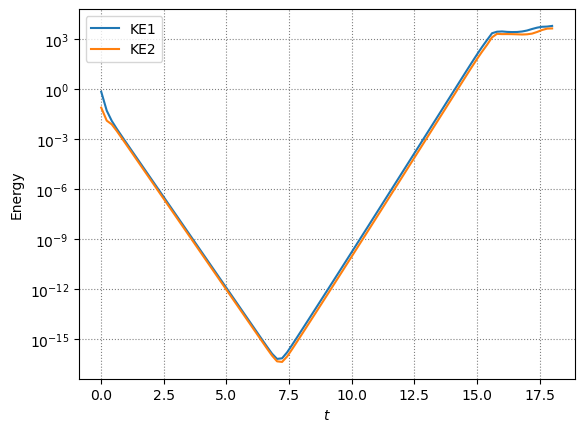

In [48]:
plot_energy("phillips_beta=10_U=1_kd2=100_ic_k6_l2")

In [ ]:
HTML(animation_streamfunction("phillips_beta=10_U=1_kd2=100_ic_k6_l2/phillips_beta=10_U=1_kd2=100_ic_k6_l2_s1.h5").to_jshtml())

We start to see an effect: the growth of the kinetic energy in the linear instability phase is slightly slower than for $\beta=0$, and in the animation there is a hint that the flow becomes more zonal. Let us increase $\beta$ a bit more.

In [57]:
kd2 = 100
problem, psi1, psi2, q1, q2 = build_problem(beta=40, U=1, kd2=100, nu=1e-4, alpha=0)

# Initial condition
psi_tilde = 1e-2
k = 6
l = 2
x, y = dist.local_grids(xbasis, ybasis)
psi1['g'] = 3*psi_tilde*np.cos(k*x + l*y)
psi2['g'] = psi_tilde*np.cos(k*x + l*y+np.pi/4)
K_carre = k**2 + l**2
q1['g'] = -3*K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi2['g']-psi1['g'])
q2['g'] = -K_carre*psi_tilde*np.cos(k*x + l*y+np.pi/4) + (kd2/2)*(psi1['g']-psi2['g'])

run_simulation(f"phillips_beta=40_U=1_kd2=100_ic_k6_l2", problem, psi1, psi2, q1, q2, stop_sim_time=100, initial_timestep=1e-2, snap_dt=1)

2025-11-14 16:49:36,659 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s
2025-11-14 16:49:36,736 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s
2025-11-14 16:49:36,834 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 4.0e+01/s
2025-11-14 16:49:36,930 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s
2025-11-14 16:49:37,026 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+01/s
2025-11-14 16:49:37,139 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s
2025-11-14 16:49:37,288 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s
2025-11-14 16:49:37,404 subsystems 0/1 INFO :: Building subproblem matric

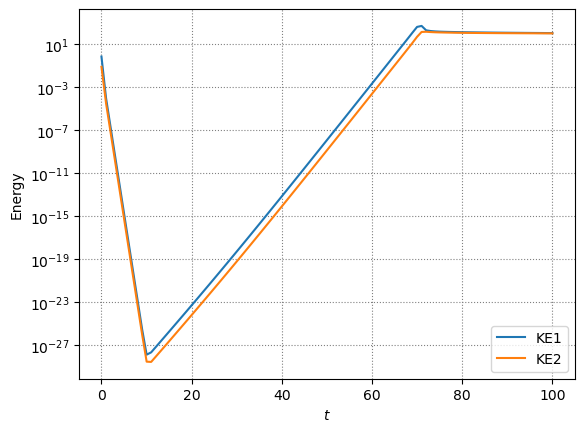

In [50]:
plot_energy("phillips_beta=40_U=1_kd2=100_ic_k6_l2")

Here we see that the growth rate of the most unstable mode is much slower than it was for $\beta=0$, and we need to run the simulation much longer to reach the saturation stage.

In [ ]:
HTML(animation_streamfunction("phillips_beta=40_U=1_kd2=100_ic_k6_l2/phillips_beta=40_U=1_kd2=100_ic_k6_l2_s1.h5").to_jshtml())

The linear instability stage of the animation shows that the wavelength of the most unstable mode has decreased compared to the $f$-plane: the zonal wavenumber is now 5, while it was 4 for $\beta=0$. In addition, we see that the flow equilibrates in a zonal configuration, which is also due to the beta-effect.

## Large $\beta$: $\beta$=O(100)

We further increase $\beta$ to $\beta=100$. This means that we have now $k_{\beta}=k_{d}$, which is the marginal value for which the baroclinic instability ceases to exist: $\beta$ is now large enough that the background potential vorticity gradient does not change sign anymore.

In [47]:
kd2 = 100
problem, psi1, psi2, q1, q2 = build_problem(beta=100, U=1, kd2=100, nu=1e-4, alpha=0)

# Initial condition
psi_tilde = 1e-2
k = 6
l = 2
x, y = dist.local_grids(xbasis, ybasis)
psi1['g'] = 3*psi_tilde*np.cos(k*x + l*y)
psi2['g'] = psi_tilde*np.cos(k*x + l*y+np.pi/4)
K_carre = k**2 + l**2
q1['g'] = -3*K_carre*psi_tilde*np.cos(k*x + l*y) + (kd2/2)*(psi2['g']-psi1['g'])
q2['g'] = -K_carre*psi_tilde*np.cos(k*x + l*y+np.pi/4) + (kd2/2)*(psi1['g']-psi2['g'])

run_simulation(f"phillips_beta=100_U=1_kd2=100_ic_k6_l2", problem, psi1, psi2, q1, q2, stop_sim_time=16, initial_timestep=1e-2)

2025-11-14 16:39:27,663 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s
2025-11-14 16:39:27,737 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 4.0e+01/s
2025-11-14 16:39:27,831 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 4.1e+01/s
2025-11-14 16:39:27,921 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2025-11-14 16:39:28,008 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2025-11-14 16:39:28,095 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+01/s
2025-11-14 16:39:28,184 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 4.4e+01/s
2025-11-14 16:39:28,277 subsystems 0/1 INFO :: Building subproblem matric

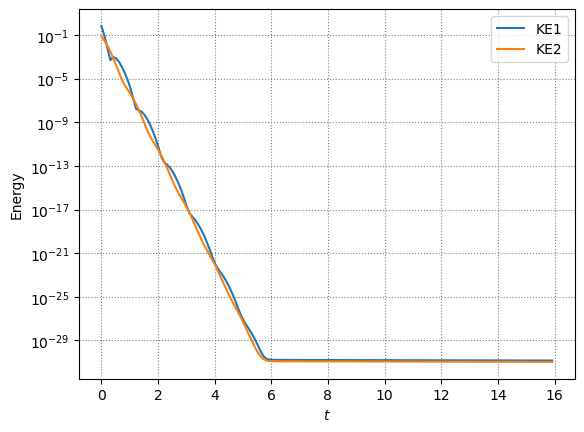

In [52]:
plot_energy("phillips_beta=100_U=1_kd2=100_ic_k6_l2")

Indeed, in this case the perturbation decays exponentially: there is no instability.